# Simulating Ontogenetic Growth

In [10]:
## Import libraries and packages

using Pkg
# import Pkg; Pkg.add("Gadfly")
# import Pkg; Pkg.add("DiffEqCallbacks")
# import Pkg; Pkg.add("Plots")
# import Pkg; Pkg.add("PGFPlots")
# import Pkg; Pkg.add("DifferentialEquations")
# import Pkg; Pkg.add("LaTeXStrings")
Pkg.activate("..")

using DifferentialEquations, Printf, DiffEqCallbacks, Plots, Printf, LaTeXStrings
gr()
# using Gadfly

Plots.GRBackend()

In [9]:
ENV["GRDIR"]=""
Pkg.build("GR")

  Building GR → `~/.julia/packages/GR/oiZD3/deps/build.log`


# Ontogenetic Growth Model
Here I simulate growth according to a biphasic ontogenetic growth model, in order to find optimal reproductive parameters - the proportion of body mass devoted, and the mass-scaling (allometric) exponent. This model consists of differential equations describing growth under two distinct ontogenetic phases. Firstly, a juvenile phase, where age is less than age-at-maturity, or $t < \alpha$ and mass is less than mass-at-maturity, or $m < m_{\alpha}$. Under this regime, energy for growth is lost only to cellular maintenance, with no diversion to reproduction. Post-maturity, individuals then lose energy to reproduction as well, at a magnitude of c, and which scales with body mass to the exponent $\rho$.

$$
\frac{dm}{dt} = am^{\beta} - bm \qquad \quad t < \alpha \\
\frac{dm}{dt} = am^{\beta} - bm - cm^{\rho} \ \ t \geq \alpha
$$

where $am^{\beta}$ is energy intake with its mass scaling exponent, $bM$ is maintenece metabolism and $cm^{\rho}$ is reproductive output.

# Optimising Life History
In order to determine "optimal" reproduction parameters, we need a quantity to be maximised. The fitness ($R_0$) of an individual growing according to the model above can be obtained by integrating the product of an individual's lifetime  reproductive output ($cm^{\rho}$) and a mortality rate, or $\mathbb{P}$(survival). How many offspring an inidivudal produces across its lifetime (mature phase, $t > \geq \alpha$) is a commonly used measure for fitness. The reason we take this product is because at any time $t$ the realised offspring produced by individual is equivalent to the instantaneous allocation, multiplied by the individual's probability of being alive at time $t$.

$$
R_0 = \int_\alpha^\infty cm^{\rho} L(M,t) dt
$$

This mortality function is set to an exponential decay function here:

$$
L(M,t) = e^{-\lambda Mt}
$$

where $\lambda$ is a rate parameter controling the rate at which the likelyhood of survival decreases.

# Define growth model as function

In [2]:
function dM(dM,M,p,t)
    intak = p[:a_0] * (abs(M[1]) ^ p[:a_b])
    maint = p[:b_0] * (abs(M[1]) ^ p[:b_b])

    if t < p[:Alph] 
        repro = 0.0
    else
        repro = p[:c_0] * (abs(M[1]) ^ p[:c_b])
        
        end
        
    dM[1] = intak - maint - repro
    dM[2] = repro * exp(-(p[:k]+p[:Z])*(t-p[:Alph]))    
end

dM (generic function with 1 method)

# Starting Parameters
In order to start the simulation, the ODE solver requires starting values for numerical integration. Here I define these:

In [3]:
hypothetical_starting_mass = 0.1
hypothetical_asymptotic_mass = 15000 # original 20000
hypothetical_starting_reproduction = 0 #c * (hypothetical_starting_mass)^ rho

0

# Growth model parameters
Here I set the values of the fixed parameters in the model:
$a$ is the potential cell growth per unit time and is derived from energy intake (J/time) divided by the energetic cost of building a cell = using the energy I have at time $t$, and given the energy it takes to build a cell, how many cells can I build? <br/>
$a^{\beta}$ (```a_b```) is the mass-scaling exponent of energy-intake rate. West et al. (2001) set this to 0.75 because they assume energy-intake rate is linked to resting metabolic rate. <br/>
$\alpha$ = 200 days

In [4]:
a = 2.15; a_b = 0.75
b = a/(hypothetical_asymptotic_mass^0.25)
c = 0.001 # West et al. assume 0.1 from Peters
alpha = 200

# alpha_vec = [10,20,30,40,60,70,80,90,100,110,120,130,140,150,160,170,180,190,120]
# # alpha_vec = 65:10:120

200

Here I initialise arrays for the variable parameters: <br/>
$c$ = proportion of body mass dedicated to reproduction. West *et al.* (2001) calculate this to be $\approx$ 10% somatic body mass. <br/>
$\rho$ = mass-scaling exponent for bodymass. <br/>
resolution = step-size for the above arrays. resolution$^2$ is the size of the resulting matrix of $c-\rho$ combinations. 

In [5]:
k_vec = [0.01]
a_b_vec = [0.75,0.85]
resolution = 100
c_vec = range(0.001,0.5,length = resolution)
c_b_vec = range(0.001,1.25,length = resolution)
xticks = 0:10:100
yticks = 0:10:100

0:10:100

# Simulation Proper
Here I loop through different mortality rates set by $\kappa$ (```k_vec```) and different scaling exponents for energy intake rate set by $\beta$ (```a_b_vec```). Within each $\kappa - \beta$ combination I then simulate growth trajectories across a large range of $c-\rho$ combinations. At this point it is useful to review the anatomy of the growth model and go "under-the-hood" of the ODE solver. Reproduction kicks in at maturity ($t = \alpha$), but the amount of energy allocated to reproduction  scales with mass ($cm^{\rho}$), therefore the larger an individual grows pre-maturity, the larger the "drop" in overall size when maturity kicks in.<br/><br/>

Numerical integrators (ODE solvers) work by taking a small step out from an initial starting value and a series of small steps thereafter. If the drop in growth caused by the onset of reproduction is larger than the mass at $t_{\alpha} - 1$, mass drops to below zero, which breaks the solver. To this point, if this drop occurs in any form, whether mass drops to below zero or not, this implies that the individual subject to this growth curve experiences shrinking at maturity, which is, of course, biologically impossible - no individual has been observed to shed mass in order to become fecund. An individual will shrink if the terminal size is too _______________ Therefore, I took measures to omit shrinking trajectories from the simulation due to biologically infeasibility. Of the remaining feasible trajectories, the optimal $c-\rho$ combination is that which maximises $R_0$ (third dimension in a heatmap). <br/><br/>

The purpose of this paper is to show whether there is theoretical scope for hyperallometric fecundity mass-scaling to evolve. Given that evolution seeks to maximise fitness ($R_0$), this scaling ocurrs when $\rho > 1$. If the $c-\rho$ combination which maximises $R_0$ for a given $\alpha$ and species (different terminal sizes) satistfies this condition, then I have shown that the theoretical model presented etc etc

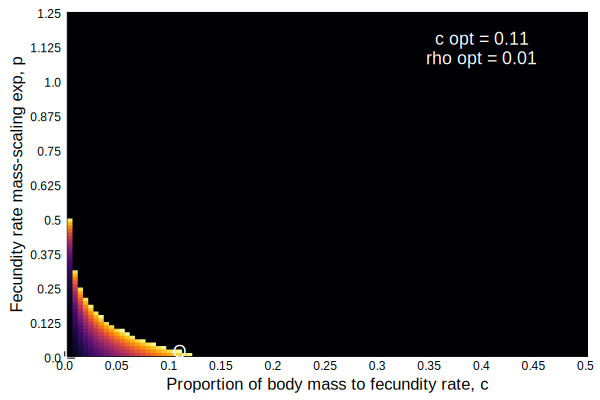


M_alpha: 14997.484233964318 grams
Saving optimisation heatmap for simulation: ../results/opt_hm_Alph=200.00_a=2.15_x=0.75_k=0.01.pdf
M_alpha: 

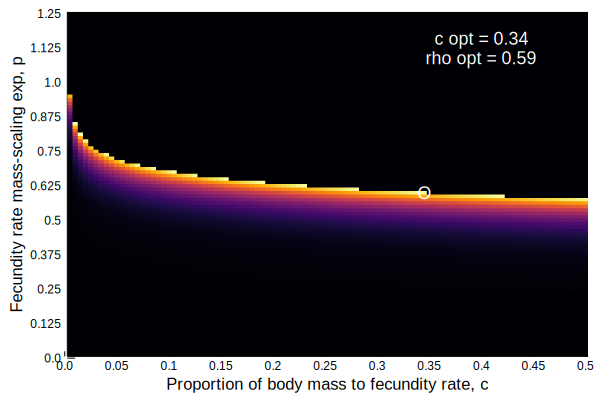

8.96235624753406e6 grams
Saving optimisation heatmap for simulation: ../results/opt_hm_Alph=200.00_a=2.15_x=0.85_k=0.01.pdf

In [11]:
for g in 1:length(k_vec) # loop through different mortality rates kappa
    k = k_vec[g]
    for h in 1:length(a_b_vec) # loop through different intake rate scalings
        a_b = a_b_vec[h]
        M0 = [hypothetical_starting_mass, hypothetical_starting_reproduction] # set array of starting values for integrator
        tspan = (0.0,1e4) # long time span ensures simulation reaches completion
        
        ## Calculate which curves have an asymptotic size (no repro) larger than m_alpha (i.e. no shrinking) ##
        ## when reproduction is from birth ##
        results_no_shrink = Array{Float64,2}(undef,resolution,resolution)
        results_optimisation = Array{Any,2}(undef,resolution,resolution)
        for i in 1:resolution # loop through empty matrix with different c and rho values
            c_0 = c_vec[i]
            for j in 1:resolution # simulate growth curve in each matrix cell and store result
                c_b = c_b_vec[j]
                p = Dict([(:a_0,a),(:a_b,a_b),
                  (:b_0,b),(:b_b,1.0),
                  (:c_0,c_0),(:c_b,c_b),
                  (:Alph,alpha),
                  (:k,k),(:Z,2/alpha)])
                prob = ODEProblem(dM,M0,tspan,p)
                sol_optimisation = solve(prob,Rosenbrock23()) 
                results_optimisation[i,j] = sol_optimisation
                global M_alph = sol_optimisation(p[:Alph])[1] # find m_alpha for your given alpha - needs fixing as finding same value in every loop
                p[:Alph] = 0.0 # update p value, MUST come AFTER prob defined
                prob = ODEProblem(dM,M0,tspan,p)
                sol_no_shrink = solve(prob,Rosenbrock23())
                results_no_shrink[i,j] = sol_no_shrink[end][1]
                
            end
        end
        print("\nM_alpha: ", M_alph, " grams")
        feas = results_no_shrink .> M_alph # bool matrix of feasible growth curves where asmyptotic size is larger than mass a maturity (i.e.) those curves with no shrinking
        x = [i.u[end][2] for i = results_optimisation] # find R0 of each simulated growth curve
        
        ## Find optimum values from matrix
        max = findmax(x .* feas)
        c_opt = c_vec[max[2][1]]
        rho_opt = c_b_vec[max[2][2]]

        ## Set plot attributes
        xticks_labels = 0.00:maximum(c_vec)/10:maximum(c_vec)
        yticks_labels = 0.00:maximum(c_b_vec)/10:maximum(c_b_vec)
        
        map = heatmap(x .* feas, xlab="Proportion of body mass to fecundity rate, c",xticks = (xticks,xticks_labels),
                            ylab="Fecundity rate mass-scaling exp, p", yticks = (yticks,yticks_labels),
                            transpose=true, legend = :none)
        annotation_string = "c opt = $(@sprintf("%.2f", c_opt))\nrho opt = $(@sprintf("%.2f", rho_opt))"
        annotate!([(80, 90, text(annotation_string, 12, :white, :topright))])
        annotate!([(max[2][1], max[2][2], text("O", 12, :white))])
        display(map)

        ## Save fitness surface
        file_name = "../results/opt_hm_Alph=$(@sprintf("%.2f", alpha))_a=$(@sprintf("%.2f", a))_x=$(@sprintf("%.2f", a_b))_k=$(@sprintf("%.2f", k_vec[g])).pdf"
#         csv_file_name = "../Results/opt_hm_Alph=$(@sprintf("%.2f", alpha))_a=$(@sprintf("%.2f", a))_x=$(@sprintf("%.2f", a_b))_k=$(@sprintf("%.2f", k_vec[g])).csv"
        print("\nSaving optimisation heatmap for simulation: ", file_name)
#         savefig(file_name) # Saves the plot from p as a .pdf vector graphic
    end
end